In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
%matplotlib inline  

/Users/Ethan/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Optimal Execution with Limit and Market Orders
## Alvaro Cartea and Sebastian Jaimungal


##### Abstract: We develop an optimal execution policy for an investor seeking to execute a large order using limit and market orders. The investor solves the optimal policy considering different restrictions on volume of both types of orders and depth at which limit orders are posted. We show how the execution policies perform when targeting the volume schedule of the Almgren-Chriss execution strategy. The different strategies considered by the investor outperform the Almgren-Chriss price with an average savings per share of about one to two and a half times the spread. This improvement over Almgren-Chriss is due to the strategies benefiting from the optimal mix of limit orders, which earn the spread, and market orders, which keep the investor's inventory schedule on target.

# Overview

- Describe basic models for financial markets (prices, trades)
- Formulate optimal trading using stochastic optimal control problems
- Solve optimizations analytically and/or numerically  
- Illustrate solutions with examples and demonstrate results via Python code and plots
- Discuss extensions and alternative approaches when appropriate

# Basics

- Limit Order Book
    - Bids & Asks
    - Limit orders vs. Market Orders
        - Passive vs. Aggressive
        - Price improvement vs. Guarantee of trade

- Algorithmic execution
    - Liquidation (acquisition): the task of selling (buying) $Q$ contracts/shares of asset beginning at time $t=0$ and ending at time $t=T.$
    - Performance is measured, e.g., by difference between average price and arrival price ("slippage") 
    - Important for active traders and large asset managers

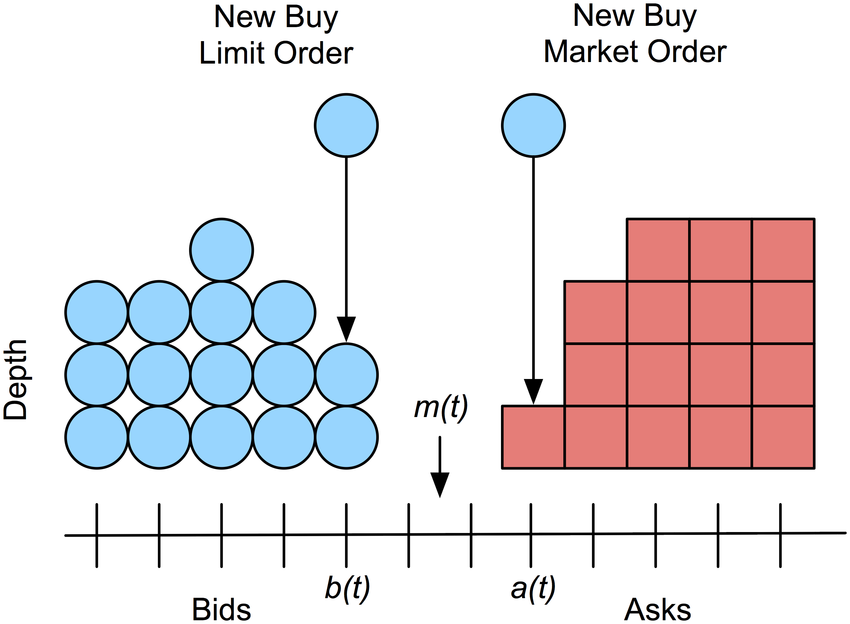

In [2]:
# Graphic of LOB
from IPython.display import Image
Image("lob.png")

# Model

The price process satisfies 

$$S_t = S_0 + \sigma(Z_t^+ - Z_t^-)$$

where $Z_t^{\pm}$ is a Poisson process.

- Poisson process $N = (N_t)_{0\leq t\leq T}\in Z_+$ with intensity $\lambda$: 
    - $N_0 = 0$
    - $N_t - N_0 \sim \textrm{Poisson}(\lambda t)$, i.e., 
    $$ P(N_t - N_0 = n) = \exp(-\lambda t)\frac{(\lambda t)^n}{n!} $$
    - $N_t - N_s$ and $N_v - N_u$ independent for disjoint intervals $[s, t]\cap [u, v]=\emptyset$.

In [ ]:
def poisson_process(lam, size):
    '''Returns binary array A of length 'size' with A[i] = 1
    if event occurs in interval i and 0 otherwise
    '''
    M = []; n=0
    while n < size:
        n += round(random.expovariate(lam)*size)
        if n < size:
            M.append(n)
    return np.array([1 if i in M else 0 for i in range(size)])

In [ ]:
'''Simulate price process'''

S_0 = 100; sigma = 0.01; level_change_intensity = 500; timesteps = 1000;
S = np.zeros(timesteps + 1)
S[0] = S_0
Zp = poisson_process(lam=level_change_intensity, size=timesteps)
Zm = poisson_process(lam=level_change_intensity, size=timesteps)

for i in range(timesteps):
    S[i+1] = S[i] + sigma * (Zp[i] - Zm[i])

plt.plot(S); plt.xlabel('time'); plt.ylabel('price');
plt.ticklabel_format(useOffset=False)

# Notation

- Lots of stochastic processes!
    - $\delta_t$: depth of limit order placement
    - $N_t$: limit order fills
        - Conditional on incoming order, exponential fill probability ($\kappa > 0$ so decreasing as $\delta$ increasing): 
        $$ P(\textrm{fill}\mid\textrm{incoming MO}) = \exp(-\kappa \delta_t). $$
        - Poisson with intensity $\lambda \exp(-\kappa\delta_t)$
    - $M_t$: market order placements (fills)        
        - Can be described by times $t^\prime_1\leq\cdots\leq t^\prime_K$: 
        $$ M_t = \sum_{k=1}^K 1_{t^\prime_k\leq t} $$
    - $X_t$: wealth, i.e., \$ collected thus far at $t$ from liquidating 
$$ dX_t = (S_{t} + \delta_{t})dN_t + (S_{t} - \Delta)dM_t $$ 
        - $\Delta$ is the half-spread
    - $q_t$: inventory
        - $q_t = Q - N_t - M_t$
 - Goal is to set up optimization problem with controls $\delta_t$ and $\mathbf{\tau}$

# Optimal Control 

$$ H(x, S, q) = \sup_{\mathbf{\tau}, \delta_t} \mathbb{E}\left[ X_T^\delta + G(Q_T^\delta) - \phi\int_0^T F(Q_s^\delta)\,ds \right] $$

In other words, maximize expected terminal wealth, subject to the following penalties:

- A function $G$ of the terminal quantity $Q_T$ 
    - e.g., $Q_T(S_T - \beta Q_T)$ 
- Running penalty of a function $F$ of the inventory over $[0, T]$
    - e.g., $F(Q_s) = (Q_s - Q_{\textrm{target}})^2$
    
  

Two control variables:
- $\delta$
    - depth of limit order placement
    - solution $\delta(q, t)$ depends on quantity and time
    - always resting an order throughout    
- $\tau=\tau_1,\ldots,\tau_Q$
    - trigger times for market orders    
    - solution $\tau_q$ depends on quantity
    - execute market order as soon as $t\geq\tau_q$  

# Dynamic Programming

- Introduce time variable $t$ to derive solutions, yield Hamilton-Jacobi-Bellman (HJB) equation
- Combined optimal stopping and control gives quasi-variational inequality (QVI):

$$ \max\left\{ \partial_t H + \gamma\left(H(t,x,S-\sigma,q) - 2H(t,x,S,q) + H(t,x,s,S+\sigma,q)\right) - \phi(q-q_\textrm{target})^2 \\
              + \sup_\delta e^{-\kappa\delta}\left[H(t,x+(S+\delta),S,q-1)-H(t,x,S,q)\right]\, ; \\
              H(t,x+(S-\Delta),S,q-1) - H(t,x,S,q) \right\} = 0 $$

- Terminal/boundary conditions
- Interpretation of terms:
    - First line: changes in price process, deviation from target penalty
    - Second line: depth control and subsequent change from fill
    - Third line: change from executing market order

## Analytical Solution

- Ansatz $H(t, x, S, q) = x + qS + h(t, q)$
- Controls as feedback:
    - $\delta(t, q) = \frac{1}{\kappa} + h(t, q) - h(t, q-1)$
    - $h(\tau_q, q-1) - h(\tau_q, q) = \Delta$
    - lower bound $\delta \geq \frac{1}{\kappa} - \Delta$
- Change of variables $h(t, q) = \frac{1}{\kappa}\log \omega(t, q)$ yields:

$$ \max\left\{\partial_t\omega(t, q) -\kappa\phi(q-q_{\textrm{target}})^2\omega(t, q) + \frac{\lambda}{e}\omega(t, q-1) ; \\
              e^{-\kappa\Delta}\omega(t, q-1)-\omega(t, q)       \right\} = 0. $$                                                 
- In the case $q_{\textrm{target}}=0$, can solve analytically
- For $q_{\textrm{AC}}$, we solve numerically

# Almgren-Chriss Trajectory

- Optimal execution strategy from classic 2000 paper.

$$ q_{\textrm{AC}}(t) = Q\,\frac{e^{\chi(T-t)} - e^{-\chi(T-t)}}{e^{\chi T} - e^{-\chi T}} 
    = Q\,\frac{\sinh(\chi(T-t))}{\sinh(\chi T)} $$

In [ ]:
# Parameters
 
T = 1.0
N = 1000
dt = T/N
lam = 10
L = lam/np.e
Q = 10
phi = 1e-3
Delta = 0.5 * 0.01
k = 50.0
tolerance = 1e-8

# Additional parameters
eta = 2e-4
b = 0
gamma = np.sqrt(phi / eta)
zeta = 1
chi = gamma

In [ ]:
Q = 10; T = 1.0; N = 1000; t = np.linspace(0, 1, N+1)    
q_ac = Q * np.sinh(chi*(T-t)) / np.sinh(chi*T)
plt.plot(q_ac); plt.title('Almgren-Chriss target trajectory');
plt.ylabel('quantity'); plt.xlabel('time');

# Numerical Solution

- Discretize in time, backwards finite difference for $\omega$ equation

In [ ]:
'''Numerical solution'''

w = np.ones(shape=(Q+1, N+1))
w[0, :] = np.exp(-k*phi* dt*np.cumsum(q_ac[::-1])[::-1]**2) # initial for target q_ac

# Loop from q=1 to q=Q
for q in range(1, Q+1):
    w[q, N] = np.exp(-k*Delta*q)    
    # Loop backwards in time
    for j in range(N, 0, -1): 
        # Backwards finite difference equation to solve numerically        
        w[q, j-1] = (w[q, j] + dt*L*w[q-1, j-1]) / (1 + dt*k*phi*(q-q_ac[j])*(q-q_ac[j])) # target q_ac

h = np.log(w) / k
delta = 1/k + (h[1:,:] - h[0:-1,:])
dist = np.maximum(1/k-Delta, delta)
mo = (delta - (1/k-Delta) > tolerance).argmin(axis=1)

In [ ]:
for i in range(len(mo) - 1):
    if mo[i] < mo[i+1]:
        mo[i] = mo[i+1]

# Algorithm Simulation 

In [ ]:
'''Simulation of algo'''

orders = []
q = np.zeros(N+1, dtype=np.int)
M = poisson_process(lam, N)

q[0] = Q
for t in range(0, N+1):
    if t > 0:
        q[t] = q[t-1]
    while q[t] > 0 and t >= mo[q[t] - 1]:
        orders.append((t, S[t] - Delta, 'MO', True))
        q[t] -= 1
    if q[t] <= 0:
        break
    if M[t]:
        d = delta[q[t]  - 1, t]
        if np.random.rand() < np.exp(-k*d):
            orders.append((t, S[t] + d, 'LO', True))
            q[t] -= 1
        else:
            orders.append((t, S[t] + d, 'miss', False))

labels = ['time', 'price', 'type', 'filled']
orders = pd.DataFrame.from_records(orders, columns=labels)

Here are the results as a pandas DataFrame:


In [ ]:
orders

In [ ]:
import seaborn as sns
pp = sns.pairplot(x_vars='time', y_vars='price', data=orders, markers=['s', 'x', 'o'], hue='type', size=7, plot_kws={'s': 100})
plt.plot(S, color='lightgray', linestyle='-');
plt.ticklabel_format(useOffset=False)

Compare simulation to Almgren-Chriss target:

In [ ]:
q[0]=Q; 
plt.plot(q);
plt.plot(mo, range(1, Q+1), 'o');
plt.plot(q_ac, '--');

In [ ]:
'''Compare simulation vs A-C target'''

algo = orders.loc[orders['type'] != 'miss', 'price'].expanding().mean().reset_index(drop=True)
ac_t = [(q_ac - quantity >= 0.5).argmin() for quantity in range(0, Q)]
ac = pd.Series(S[ac_t]).expanding().mean()
plt.subplots()
algo.plot();
ac.plot(linestyle='--');

In [ ]:
df = pd.read_csv('10000.csv')
df.describe()

## Variations 

- Posting only at the best bid/ask:
     $$   \max_{\ell\in\{0,1\}} $$ 
- ...and choosing quantity:
     $$   \max_{\ell\in\{0,\ldots,q\}} $$ 
- ...and possibly several levels, quantities?

## Extensions
- Transaction cost fees/rebates
- Add drift to price process
- Incorporate adverse selection of limit orders
- Dynamic instead of static parameters ($\lambda, \kappa, $ etc.)

# Conclusions

- Provides clean and fairly general framework for optimal execution
- Ignores some practical considerations and details needed for implementation
- Demonstrates that a combination of passive and aggressive orders may be effective
- Can be used as part of a multi-pronged approach for algorithm design

<img src="thanks.png">